In [1]:
import openseespy.opensees as ops
import opsvis as opsv
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
# import ASRE models
cur_dir = os.getcwd()
ASREpy_dir = os.path.join(os.path.dirname(os.path.dirname(cur_dir)))
sys.path.append(ASREpy_dir)
import ASREpy.ground_deformation_models as gdm
import ASREpy
import pandas as pd
from scipy import interpolate
np.set_printoptions(threshold=np.inf)

In [2]:
def prepare_greenfield_disp(val_data_dir, vl, beamX):
    ## Prepare Ux-GF
    # Read Ux-GF and Uz-GF
    dispX_gf_file = os.path.join(val_data_dir, f'FranzaDeJong-'
                        f"VL{str(vl*100).replace('.', 'p')}-Ux-GF.csv")
    dispX_gf = pd.read_csv(dispX_gf_file, header=None)

    dispZ_gf_file = os.path.join(val_data_dir, f'FranzaDeJong-'
                        f"VL{str(vl*100).replace('.', 'p')}-Uz-GF.csv")
    dispZ_gf = pd.read_csv(dispZ_gf_file, header=None)
    # Add the left half of Ux-GF and Uz-GF
    left_half = dispX_gf.copy()
    left_half[0] = -left_half[0]
    left_half[1] = -left_half[1]
    dispX_gf = pd.concat([left_half, dispX_gf])
    dispX_gf = dispX_gf.sort_values(by = 0).reset_index(drop = True)

    left_half = dispZ_gf.copy()
    left_half[0] = -left_half[0]
    dispZ_gf = pd.concat([left_half, dispZ_gf])
    dispZ_gf = dispZ_gf.sort_values(by = 0).reset_index(drop = True)
    # Interpolate the dispX_gf with beamX mesh
    f = interpolate.interp1d(dispX_gf[0], dispX_gf[1], fill_value='extrapolate')
    dispX_gf = f(beamX)

    f = interpolate.interp1d(dispZ_gf[0], dispZ_gf[1], fill_value='extrapolate')
    dispZ_gf = f(beamX)
    return dispX_gf/1000, dispZ_gf/1000

def plot_verification(val_data_dir, frame_id, qz_id, beamX, model, axes, model_el = None):
    
    ## Prepare Ux-GF
    # Read Ux-GF and Uz-GF
    dispX_gf_file = os.path.join(val_data_dir, "FranzaDeJong-VL2p0-Ux-GF.csv")
    dispX_gf = pd.read_csv(dispX_gf_file, header=None)

    dispZ_gf_file = os.path.join(val_data_dir, "FranzaDeJong-VL2p0-Uz-GF.csv")
    dispZ_gf = pd.read_csv(dispZ_gf_file, header=None)

    dispL_asre_file =  os.path.join(val_data_dir, f'{frame_id}_'
                        f"{qz_id}_ux.csv")
    dispL_asre_Franza = pd.read_csv(dispL_asre_file, header=None)

    dispV_asre_file =  os.path.join(val_data_dir, f'{frame_id}_'
                        f"{qz_id}_uz.csv")
    dispV_asre_Franza = pd.read_csv(dispV_asre_file, header=None)

    # Sort the disp in file from left to right
    left_half = dispX_gf.copy()
    left_half[0] = -left_half[0]
    left_half[1] = -left_half[1]
    dispX_gf = pd.concat([left_half, dispX_gf])
    dispX_gf = dispX_gf.sort_values(by = 0).reset_index(drop = True)
    
    left_half = dispZ_gf.copy()
    left_half[0] = -left_half[0]
    dispZ_gf = pd.concat([left_half, dispZ_gf])
    dispZ_gf = dispZ_gf.sort_values(by = 0).reset_index(drop = True)
    
    left_half = dispL_asre_Franza.copy()
    left_half[0] = -left_half[0]
    left_half[1] = -left_half[1]
    dispL_asre_Franza = pd.concat([left_half, dispL_asre_Franza])
    dispL_asre_Franza = dispL_asre_Franza.sort_values(by = 0).reset_index(drop = True)

    left_half = dispV_asre_Franza.copy()
    left_half[0] = -left_half[0]
    dispV_asre_Franza = pd.concat([left_half, dispV_asre_Franza])
    dispV_asre_Franza = dispV_asre_Franza.sort_values(by = 0).reset_index(drop = True)
    # Interpolate the dispX_gf with beamX mesh
    f = interpolate.interp1d(dispX_gf[0], dispX_gf[1], fill_value='extrapolate')
    dispX_gf = f(beamX)

    f = interpolate.interp1d(dispZ_gf[0], dispZ_gf[1], fill_value='extrapolate')
    dispZ_gf = f(beamX)

    f = interpolate.interp1d(dispL_asre_Franza[0], dispL_asre_Franza[1], fill_value='extrapolate')
    dispL_asre_Franza = f(beamX)

    f = interpolate.interp1d(dispV_asre_Franza[0], dispV_asre_Franza[1], fill_value='extrapolate')
    dispV_asre_Franza = f(beamX)
    
    axes[0].plot(beamX, dispX_gf, 'r:', label = 'experiment')
    axes[1].plot(beamX, dispZ_gf, 'r:', label = 'experiment')

    axes[0].plot(beamX, dispL_asre_Franza, 'b', label = 'ASRE_Franza')
    axes[1].plot(beamX, -dispV_asre_Franza, 'b', label = 'ASRE_Franza')
    
    if model_el is not None:
        axes[0].plot(beamX, model.beam_DispL[model.footing_nodes_ind]*1000, 'bx', label = 'ASREpy_ep')
        axes[1].plot(beamX, model.beam_DispV[model.footing_nodes_ind]*1000, 'bx', label = 'ASREpy_ep')

        axes[0].plot(beamX, model_el.beam_DispL[model.footing_nodes_ind]*1000, 'b^', label = 'ASREpy_el')
        axes[1].plot(beamX, model_el.beam_DispV[model.footing_nodes_ind]*1000, 'b^', label = 'ASREpy_el')
    else:
        axes[0].plot(beamX, model.beam_DispL[model.footing_nodes_ind]*1000, 'bx', label = 'ASREpy')
        axes[1].plot(beamX, model.beam_DispV[model.footing_nodes_ind]*1000, 'bx', label = 'ASREpy')


    axes[0].legend()
    axes[1].legend()

    axes[0].set_title(f'{frame_id}, {qz_id}, Ux')
    axes[1].set_title(f'{frame_id}, {qz_id}, Uz')

    axes[0].set_xlim([0, 15])
    axes[1].set_xlim([0, 15])
    axes[0].set_ylim([-60, 36])
    axes[1].set_ylim([-60, 36])
    
val_data_dir = r"VerificationData"

In [3]:
import numpy as np
import openseespy.opensees as ops

# 材料属性
E = 54e9  # 杨氏模量 (Pa)
rho = 2700  # 密度 (kg/m^3)
nu = 0.3  # 泊松比
t = 0.003125 * 68  # 墙体厚度 (m)
g = 9.81  # 重力加速度 (m/s^2)

mq, nq, hq = 5, 6, 2  # 网格划分
h = 0.0381 * 68 / hq  # 单层高度 (m)
b = 0.0762 * 68 / mq  # 单个网格宽度 (m)
l = 0.258 * 68 / nq  # 单个网格长度 (m)

tolerance = 1e-6
ops.wipe()
ops.model('basic', '-ndm', 3, '-ndf', 6)

# 定义节点
nodes = {}
node_id = 1

def get_node_id(x, y, z):
    """获取或创建给定坐标的节点ID"""
    global node_id
    for (x_exist, y_exist, z_exist), existing_node_id in nodes.items():
        if (abs(x - x_exist) < tolerance and
            abs(y - y_exist) < tolerance and
            abs(z - z_exist) < tolerance):
            return existing_node_id

    nodes[(x, y, z)] = node_id
    ops.node(node_id, x, y, z)
    node_id += 1
    return node_id - 1

# 生成模型节点
for layer in range(3):  
    z_offset = layer * h * hq
    for col in range(7):  
        x_offset = col * b * mq  
        for row in range(2):  
            y_offset = row * l * nq
            get_node_id(x_offset, y_offset, z_offset)          

# 施加约束
# for coords, node_i in nodes.items():
#     x, y, z = coords
#     if x == 0 and z == 0:  
#         ops.fix(node_i, 1, 1, 1, 0, 0, 0)
#     elif x == b * 6 * mq and z == 0:  
#         ops.fix(node_i, 1, 1, 1, 0, 0, 0)

# 定义材料
ops.section('ElasticMembranePlateSection', 1, E, nu, t, rho)

element_id = 1
shell_elements = []  

# 竖向单元
for layer in range(2 * hq):  
    for col in range(7):  
        base_x = col * b * mq
        for row in range(nq):
            base_y = row * l 
            ele_nodes = [
                get_node_id(base_x, base_y, layer * h),
                get_node_id(base_x, base_y + l, layer * h),
                get_node_id(base_x, base_y + l, layer * h + h),
                get_node_id(base_x, base_y, layer * h + h)
            ]
            ops.element("ShellMITC4", element_id, *ele_nodes, 1)
            shell_elements.append(ele_nodes)
            element_id += 1

# 水平单元
for layer in range(3):  
    for col in range(6 * mq):  
        base_x = col * b 
        for row in range(nq):  
            base_y = row * l 
            ele_nodes = [
                get_node_id(base_x, base_y, layer * h * hq),
                get_node_id(base_x + b, base_y, layer * h * hq),
                get_node_id(base_x + b, base_y + l, layer * h * hq),
                get_node_id(base_x, base_y + l, layer * h * hq)
            ]
            ops.element("ShellMITC4", element_id, *ele_nodes, 1)
            shell_elements.append(ele_nodes)
            element_id += 1

# 计算结构自重并施加荷载
self_weight = rho * g * t  # 每单位面积的自重 (N/m^2)
num_of_nodes = len(nodes)
self_weight_unit = np.zeros(num_of_nodes * 6).astype(float)  # 初始化为零

for ele_nodes in shell_elements:
    coords = np.array([ops.nodeCoord(node_id) for node_id in ele_nodes])  # 获取四个节点坐标
    vec1 = coords[1] - coords[0]  
    vec2 = coords[3] - coords[0]  
    vec3 = coords[2] - coords[1]  
    vec4 = coords[3] - coords[2]  

    # 计算面积（拆分成两个三角形）
    area = 0.5 * np.linalg.norm(np.cross(vec1, vec2)) + 0.5 * np.linalg.norm(np.cross(vec3, vec4))
    total_self_weight = area * self_weight  

    # 自重均分到四个节点
    for node_id in ele_nodes:
        index = (node_id - 1) * 6 + 2  # 计算在 self_weight_unit 中的索引（Z 方向）
        self_weight_unit[index] += total_self_weight / 4  # 均分到四个节点

# 施加荷载
ops.timeSeries("Linear", 1)
ops.pattern("Plain", 1, 1)
for i in range(num_of_nodes):
    node_id = i + 1  # 因为 OpenSees 的节点从 1 开始
    force_z = self_weight_unit[i * 6 + 2]
    if abs(force_z) > tolerance:  # 只对非零荷载节点施加力
        ops.load(node_id, 0, 0, -force_z, 0, 0, 0)

# **查询并记录基础节点**
footing_nodes_ind = []
footing_coord_x = []
footing_coord_y = []
footing_coord_z = []

for (x, y, z), node_id in nodes.items():
    if abs(z) < tolerance:  # z=0 为基础节点
        footing_nodes_ind.append(node_id)
        footing_coord_x.append(x)
        footing_coord_y.append(y)
        footing_coord_z.append(z)

# 转换为 NumPy 数组
footing_nodes_ind = np.array(footing_nodes_ind).astype(int)
footing_coord_x = np.array(footing_coord_x).astype(float)
footing_coord_y = np.array(footing_coord_y).astype(float)
footing_coord_z = np.array(footing_coord_z).astype(float)

# # 输出基础节点信息
# print("基础节点编号:", footing_nodes_ind)
# print("基础节点坐标 (x):", footing_coord_x)
# print("基础节点坐标 (y):", footing_coord_y)
# print("基础节点坐标 (z):", footing_coord_z)

In [4]:
# 创建分析
ops.system("FullGeneral")
ops.numberer("Plain")
ops.constraints("Plain")
ops.integrator("LoadControl", 1.0)
ops.algorithm("Linear")
ops.analysis("Static")
# 分析
analysis_result = ops.analyze(1)
if analysis_result != 0:
    print("分析未能收敛，错误代码:", analysis_result)
else:
    # 获取刚度矩阵
    N = ops.systemSize()
    K = ops.printA('-ret')
    K = np.array(K).reshape((N, N))
    # 输出刚度矩阵
    print("刚度矩阵 K:")
    # print(K)

刚度矩阵 K:


<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>

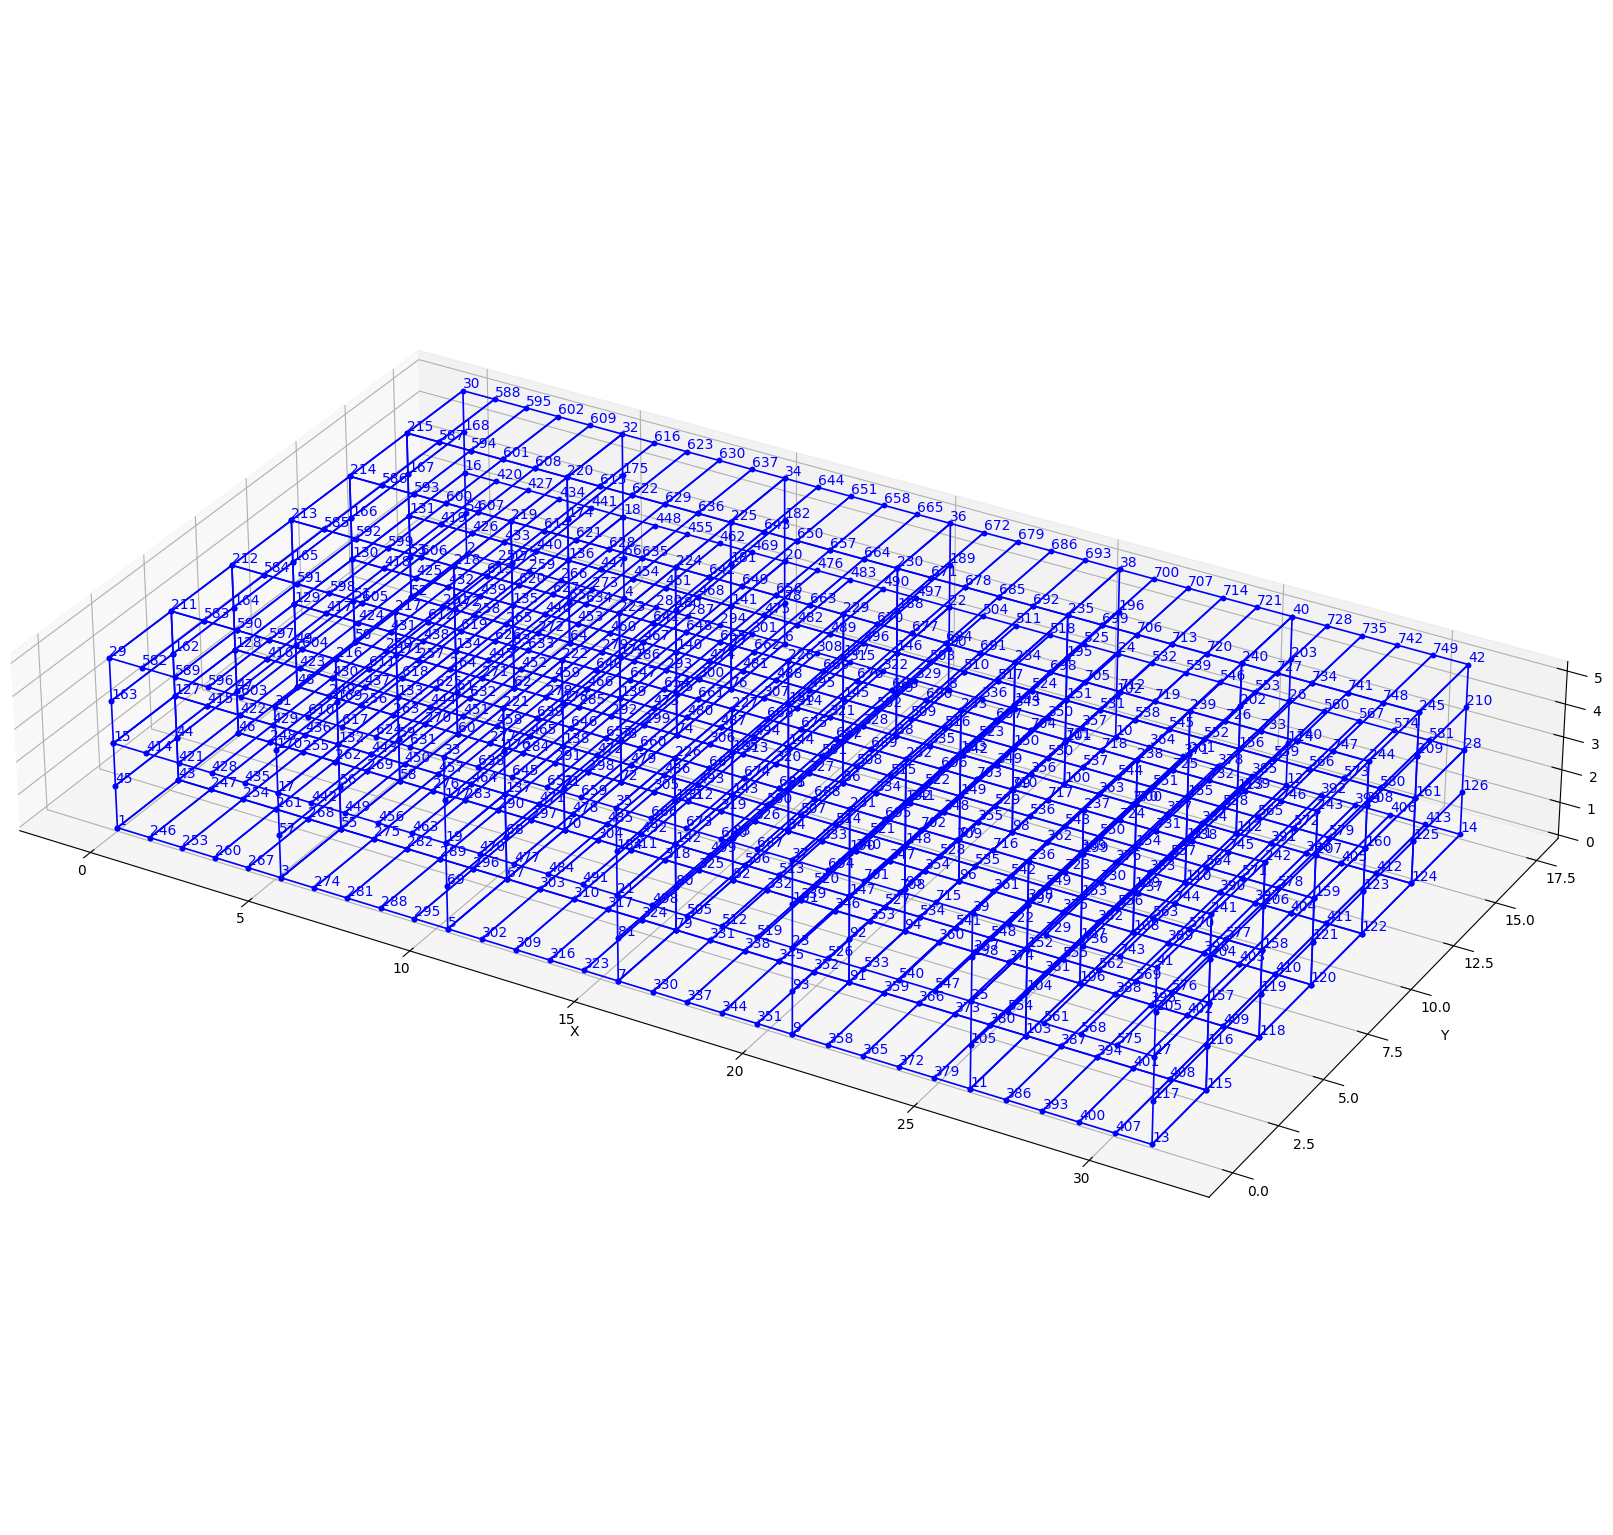

In [5]:
# plt.figure(figsize=(20, 10))
opsv.plot_model(fig_wi_he=(50, 50), node_labels=1, element_labels=0)

In [6]:
# Shift the coordinates by 15m to the left, this does not affect the model stiffness
footing_coord_x = footing_coord_x - 31.09/2 
# Prepare the ground deformation
vl = 2.0/100
dispX_gf, dispZ_gf = prepare_greenfield_disp(val_data_dir, vl, footing_coord_x)
Es = 25e6
nis = 0.25
mu_int = np.tan(30*np.pi/180)
footing_ele_width = l
footing_ele_length = b
footing_ele_width = np.array([footing_ele_width]*footing_nodes_ind.size).astype(float)
footing_ele_length= np.array([footing_ele_length]*footing_nodes_ind.size).astype(float)
qz = -1 * self_weight_unit
# footing_ele_length = ele_size_footing * np.ones_like(footing_nodes_ind).astype(float)
# footing_ele_width = bfoot * np.ones_like(footing_nodes_ind).astype(float)


# plot_verification(val_data_dir, 'FR2c2', 'q10', model.footing_coord_x, model, axes, model_el)


In [7]:
# footing
footing_nodes_ind = footing_nodes_ind - 1 # use index from 0


In [8]:
model_el = ASREpy.ASRE_2D_frame_model(ops, footing_nodes_ind, footing_coord_x, 
                                   footing_coord_y, footing_coord_z,
                                   footing_ele_length, footing_ele_width, 
                                   qz, 'elastic')
# model.set_soil_properties(Es, nis, mu_int)
model_el.set_soil_properties(Es, nis, mu_int)
# model.run_model(dispX_gf, np.zeros_like(dispX_gf), dispZ_gf, 'disp')
model_el.run_model(dispX_gf, np.zeros_like(dispX_gf), dispZ_gf, 'disp')
# model_el.run_model(np.zeros_like(dispX_gf), np.zeros_like(dispX_gf), np.zeros_like(dispX_gf)-0.01, 'disp')
# fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True,
#                                         figsize=(12, 6))

True

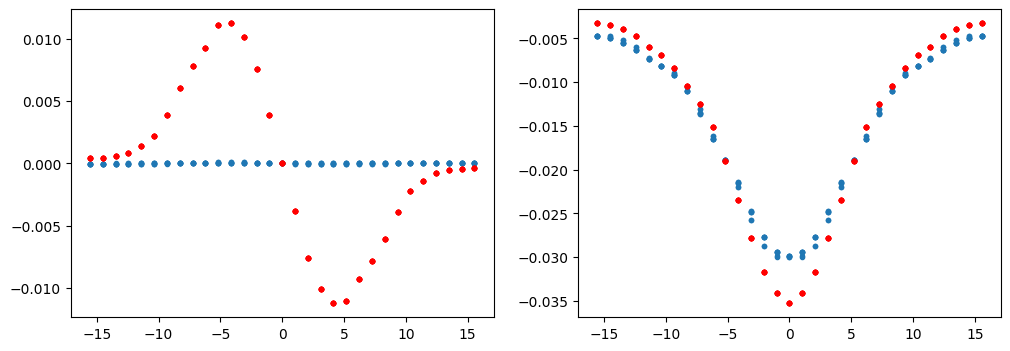

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True,
                                        figsize=(12, 4))
axes[0].plot(footing_coord_x, model_el.result_array_ptr[footing_nodes_ind*6+0],'.', label = 'ASREpy_el')
axes[0].plot(footing_coord_x, dispX_gf, 'r.', label = 'greenfield')
axes[1].plot(footing_coord_x, model_el.result_array_ptr[footing_nodes_ind*6+2],'.', label = 'ASREpy_el')
axes[1].plot(footing_coord_x, dispZ_gf, 'r.', label = 'greenfield')

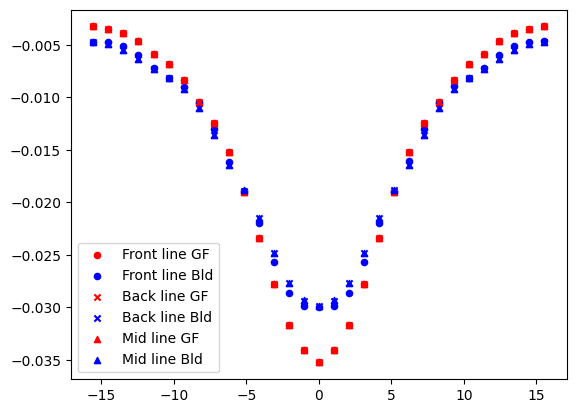

In [10]:
front_line_ind = np.concatenate((np.arange(1, 15, 2), np.arange(246, 408, 7))) - 1

mid_ind = []
for i in range(1, 750):
    if ops.nodeCoord(i)[1] == 8.772 and ops.nodeCoord(i)[2] == 0:
        mid_ind.append(i)
# back_line_ind = np.concatenate((np.arange(2, 15, 2), np.arange(252, 414, 7))) - 1
back_line_ind = []
for i in range(1, 750):
    if ops.nodeCoord(i)[1] == 2.924 and ops.nodeCoord(i)[2] == 0:
        back_line_ind.append(i)
mid_ind = np.array(mid_ind) - 1
back_line_ind = np.array(back_line_ind) - 1
front_ind_in_footing = [np.where(footing_nodes_ind == i)[0][0] for i in front_line_ind]
back_ind_in_footing = [np.where(footing_nodes_ind == i)[0][0] for i in back_line_ind]
mid_ind_in_footing = [np.where(footing_nodes_ind == i)[0][0] for i in mid_ind]
plt.scatter(footing_coord_x[front_ind_in_footing], dispZ_gf[front_ind_in_footing], s=20, c='r', marker='o', label='Front line GF')
plt.scatter(footing_coord_x[front_ind_in_footing], model_el.result_array_ptr[footing_nodes_ind[front_ind_in_footing]*6 + 2], s=20, c='b', marker='o', label='Front line Bld')
plt.scatter(footing_coord_x[back_ind_in_footing], dispZ_gf[back_ind_in_footing], s=20, c='r', marker='x', label='Back line GF')
plt.scatter(footing_coord_x[back_ind_in_footing], model_el.result_array_ptr[footing_nodes_ind[back_ind_in_footing]*6 + 2], s=20, c='b', marker='x', label='Back line Bld')
plt.scatter(footing_coord_x[mid_ind_in_footing], dispZ_gf[mid_ind_in_footing], s=20, c='r', marker='^', label='Mid line GF')
plt.scatter(footing_coord_x[mid_ind_in_footing], model_el.result_array_ptr[footing_nodes_ind[mid_ind_in_footing]*6 + 2], s=20, c='b', marker='^', label='Mid line Bld')
plt.legend()

In [12]:
qz = -1 * self_weight_unit
model = ASREpy.ASRE_2D_frame_model(ops, footing_nodes_ind, footing_coord_x, 
                                   footing_coord_y, footing_coord_z,
                                   footing_ele_length, footing_ele_width, 
                                   qz, 'elasto-plastic')
model.set_soil_properties(Es, nis, mu_int)

model.run_model(dispX_gf, np.zeros_like(dispX_gf), dispZ_gf, 'disp')
# model.run_model(np.zeros_like(dispX_gf), np.zeros_like(dispX_gf), np.zeros_like(dispZ_gf), 'disp')

load step: 0 iter: 0 residual1: 122137 residual30 CImax: 117.827 perr: 0.0200386
load step: 0 iter: 1 residual1: 30837.1 residual30 CImax: 9075.79 perr: 0.000806752
load step: 0 iter: 2 residual1: 12869.6 residual30 CImax: 1560.34 perr: 0.000584694
load step: 0 iter: 3 residual1: 9278.78 residual30 CImax: 2529.22 perr: 0.00029589
load step: 0 iter: 4 residual1: 6792.43 residual30 CImax: 464.538 perr: 0.000260951
load step: 0 iter: 5 residual1: 5109.37 residual30 CImax: 341.356 perr: 0.000199144
load step: 0 iter: 6 residual1: 3834.04 residual30 CImax: 312.655 perr: 0.000152175
load step: 0 iter: 7 residual1: 2876.7 residual30 CImax: 402.573 perr: 0.000114719
load step: 0 iter: 8 residual1: 2158.84 residual30 CImax: 159.586 perr: 8.61388e-05
load step: 0 iter: 9 residual1: 1622.63 residual30 CImax: 151.487 perr: 6.45429e-05
load step: 0 iter: 10 residual1: 1222.9 residual30 CImax: 208.729 perr: 4.83384e-05
load step: 0 iter: 11 residual1: 925.313 residual30 CImax: 129.974 perr: 3.62116e

True

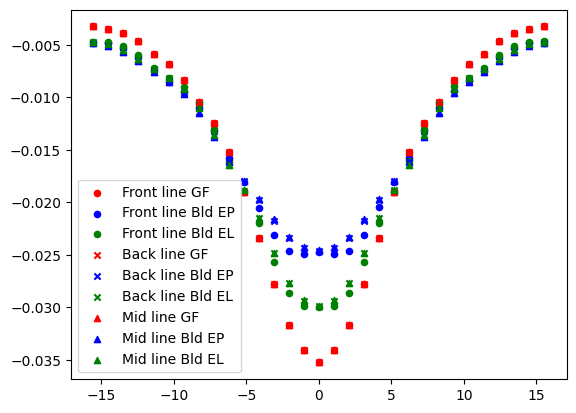

In [15]:
front_line_ind = np.concatenate((np.arange(1, 15, 2), np.arange(246, 408, 7))) - 1

mid_ind = []
for i in range(1, 750):
    if ops.nodeCoord(i)[1] == 8.772 and ops.nodeCoord(i)[2] == 0:
        mid_ind.append(i)
# back_line_ind = np.concatenate((np.arange(2, 15, 2), np.arange(252, 414, 7))) - 1
back_line_ind = []
for i in range(1, 750):
    if ops.nodeCoord(i)[1] == 2.924 and ops.nodeCoord(i)[2] == 0:
        back_line_ind.append(i)
mid_ind = np.array(mid_ind) - 1
back_line_ind = np.array(back_line_ind) - 1
front_ind_in_footing = [np.where(footing_nodes_ind == i)[0][0] for i in front_line_ind]
back_ind_in_footing = [np.where(footing_nodes_ind == i)[0][0] for i in back_line_ind]
mid_ind_in_footing = [np.where(footing_nodes_ind == i)[0][0] for i in mid_ind]
plt.scatter(footing_coord_x[front_ind_in_footing], dispZ_gf[front_ind_in_footing], s=20, c='r', marker='o', label='Front line GF')
plt.scatter(footing_coord_x[front_ind_in_footing], model.result_array_ptr[footing_nodes_ind[front_ind_in_footing]*6 + 2], s=20, c='b', marker='o', label='Front line Bld EP')
plt.scatter(footing_coord_x[front_ind_in_footing], model_el.result_array_ptr[footing_nodes_ind[front_ind_in_footing]*6 + 2], s=20, c='g', marker='o', label='Front line Bld EL')
plt.scatter(footing_coord_x[back_ind_in_footing], dispZ_gf[back_ind_in_footing], s=20, c='r', marker='x', label='Back line GF')
plt.scatter(footing_coord_x[back_ind_in_footing], model.result_array_ptr[footing_nodes_ind[back_ind_in_footing]*6 + 2], s=20, c='b', marker='x', label='Back line Bld EP')
plt.scatter(footing_coord_x[back_ind_in_footing], model_el.result_array_ptr[footing_nodes_ind[back_ind_in_footing]*6 + 2], s=20, c='g', marker='x', label='Back line Bld EL')
plt.scatter(footing_coord_x[mid_ind_in_footing], dispZ_gf[mid_ind_in_footing], s=20, c='r', marker='^', label='Mid line GF')
plt.scatter(footing_coord_x[mid_ind_in_footing], model.result_array_ptr[footing_nodes_ind[mid_ind_in_footing]*6 + 2], s=20, c='b', marker='^', label='Mid line Bld EP')
plt.scatter(footing_coord_x[mid_ind_in_footing], model_el.result_array_ptr[footing_nodes_ind[mid_ind_in_footing]*6 + 2], s=20, c='g', marker='^', label='Mid line Bld EL')
plt.legend()